<h1><center>Projet: Détection de la démence</center></h1>

<h1> 1. Définition de l'objectif</h1>

Mettre en place un modèle prédictif chargé de détecter la présence de démence chez un patient, en fonction des données cliniques disponibles.\
L'évaluation de certaines métriques telles que la précision, le recall, le f1-score et l'accuracy, permettra de juger de la performance du modèle prédictif.

# 2. Analyse exploratoire de données (EDA)

<h2><center>Analyse de forme du dataset</center></h2>

In [1]:
# Pour ignorer les warnings
import warnings
warnings.filterwarnings("ignore")

# Importation des librairies de dataviz
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importation des librairies de calcul satistique
from scipy.stats import pearsonr, chi2_contingency, shapiro, bartlett, wilcoxon, ttest_ind

# Importation des librairies de modèles de machine learning
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score, recall_score

# Importation des librairies de data-preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Permet de visualiser toutes les lignes et toutes les colonnes du dataframe
# pd.set_option('max_columns',15)
# pd.set_option('max_rows',373)

# Importation et affichage du dataframe
data = pd.read_csv('oasis_longitudinal.csv') 
data.head()

Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034

**Identification de la target** : Group

In [3]:
data.shape

(373, 15)

**Nombre de lignes et de colonnnes** : 373 lignes et 15 colonnes

In [4]:
data.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object

In [5]:
data.dtypes.value_counts()

float64    5
object     5
int64      5
dtype: int64

**Type de variables** :  
- Variables de type float64: 5 
- Variables de type int64: 5 
- Variables de type object: 5

In [6]:
data.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

**Identification des valeurs manquantes** : 
- 19 valeurs manquantes pour la variable SES 
- 2 valeurs manquantes pour la variable MMSE

<h2><center>Analyse de fond du dataset</center></h2>

- **Variables supprimées**: 
    - Subject ID: identifiant du patient
    - MRI ID: identifiant de l'IRM du patient
    - Hand: main dominante, variable peu pertinente car tous les patients sont droitiers.

In [7]:
data.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1, inplace = True)
data.head()

Group  Visit  MR Delay M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1         0   M   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2       457   M   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1         0   M   75    12  NaN  23.0  0.5  1678  0.736   
3     Demented      2       560   M   76    12  NaN  28.0  0.5  1738  0.713   
4     Demented      3      1895   M   80    12  NaN  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

### Analyse de la variable à expliquer

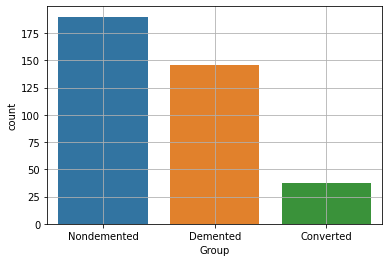

In [8]:
sns.countplot(data['Group']);
plt.grid()

In [9]:
# affiche la distribution de la variable 'group' en pourcentage
data['Group'].value_counts(normalize = True)*100

Nondemented    50.938338
Demented       39.142091
Converted       9.919571
Name: Group, dtype: float64

- Group:  en fonction de leur état cognitif, les patients sont regroupés dans 3 classes.\
    Demented(souffre de démence), Nondemented(pas de démence), Converted(démence en cours de développement)\
On observe un déséquilibre de classe, 50% de patients ne souffrant pas de démence, 40% de patients souffrant de démence et 10% de patients qui développent une démence, au cours de l'étude.

### Analyse des variables explicatives
- **Analyse des variables explicatives**:
    - **Variables quantitatives**: 
        - nWBV: Volume total de l'encéphale, normalisé 
        - ASF(Atlas Scaling Factor): Volume intracranien du patient, normalisé
        - eTIV: Estimation du volume intracranien du patient, exprimé en mm3
        - Visit: Nombre de visite nécéssaire pour statuer sur la présence d'une démence
        - MR Delay: Non défini, probablement lié à la mesure de l'IRM
        - Age: Age du patient, exprimé en année
        - EDUC: Age du patient à la fin de ces études, exprimé en année
        - MMSE: Mini-Mental State Examination score (de 0(pire) à 30(meilleur)): C'est un test d'évaluation des fonctions cognitives et des capacités mnésiques d'un individu.

In [10]:
# changement du nom des variables 'MR Delay'et 'M/F'  à cause de 'l'espace' qui peut créer des erreurs lors de l'exécution de certaine cellule
data.rename({'MR Delay':'MRDelay','M/F':'Sex'}, axis=1, inplace = True)
data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0   M   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457   M   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1        0   M   75    12  NaN  23.0  0.5  1678  0.736   
3     Demented      2      560   M   76    12  NaN  28.0  0.5  1738  0.713   
4     Demented      3     1895   M   80    12  NaN  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

In [11]:
variables_quantitatives = ['nWBV', 'ASF', 'eTIV','Visit', 'Age', 'EDUC', 'MRDelay', 'MMSE']

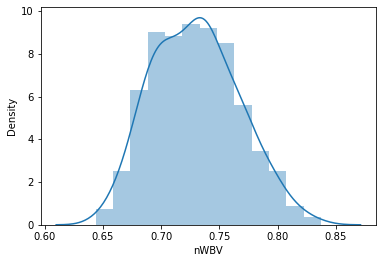

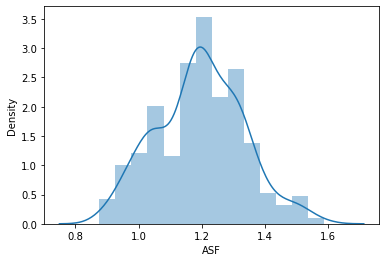

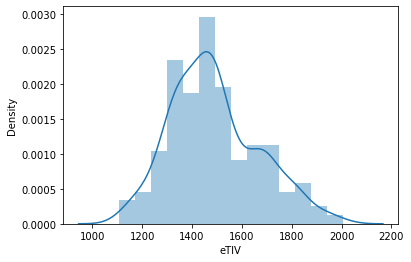

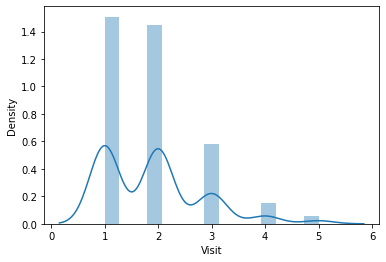

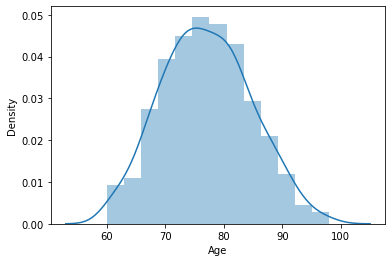

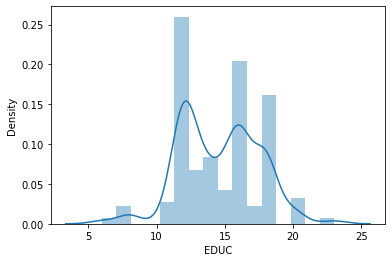

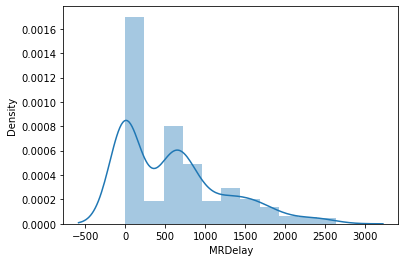

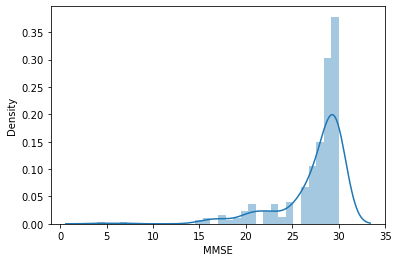

In [12]:
# Affiche la distribution des variables quantitatives
for colonne in variables_quantitatives:
    plt.figure()
    sns.distplot(data[colonne])

- **Analyse des distributions**\
Les variables 'nWBV' et  'Age' semblent présenter une distribution gaussienne.     

- **Analyse des variables explicatives**:
    - **Variable qualitatives ou catégoriellles**:
        - SES: Statut socio-économique tel qu'évalué par l'indice Hollingshead (de 1(meilleur) à 5(plus bas))
        - CDR: Taux de démence clinique (0 = pas de démence, 0.5 = démence très sévère, 1 = démence sévère, 2 = démence modérée)  
        - M/F: Sexe du patient

In [13]:
variables_qualitatives = ['Sex', 'SES', 'CDR']

In [14]:
# affiche les modalités prises par les différentes variables qualitatives
for colonne in variables_qualitatives:
    print(f'{colonne :.<90}{data[colonne].unique()}')

Sex.......................................................................................['M' 'F']
SES.......................................................................................[ 2. nan  3.  4.  1.  5.]
CDR.......................................................................................[0.  0.5 1.  2. ]


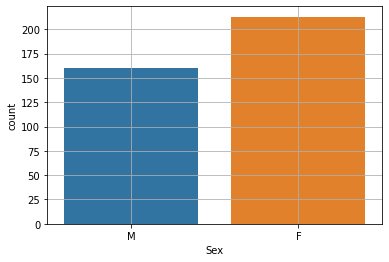

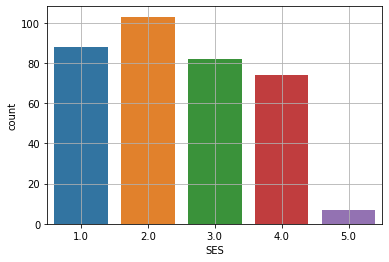

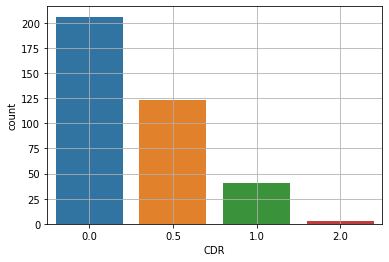

In [15]:
# Affiche la distribution des variables qualitatives
for colonne in ['Sex', 'SES', 'CDR']:
    plt.figure()
    sns.countplot(data[colonne])
    plt.grid()

In [16]:
# affiche le pourcentage de valeurs manquantes pour la variable 'SES'
data['SES'].isna().sum()/data.shape[0]*100

5.093833780160858

- **Analyse des distributions**\
Les femmes sont d'avantage représentées que les hommes.\
Presque tous les status socio-économique sont représentés. La distribution est presque uniforme. Il y a 5% de valeurs manquantes pour la variable SES. 

<h1><center>Tests statistiques</center></h1>

**Description des tests statistiques usuels**:\
Les tests stastiques, présentés ci-dessous, seront utiles dans l'étude des corrélations entre variables.

**Test de Pearson**\
*Test de dépendance entre 2 variables quantitatives*\
Hypothèse nulle H0: les 2 variables sont indépendantes

In [17]:
def pearson_test(colonne1, colonne2):
    alpha = 0.05 # seuil de risque à 5%
    stat, p = pearsonr(colonne1, colonne2)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Coefficient corrélation de Pearson**\
*Quantifie la corrélation entre 2 variables quantitatives*

In [18]:
def pearson_coef(colonne1, colonne2):
    stat, p = pearsonr(colonne1, colonne2)
    return stat

**Test du chi2**\
*Test de dépendance entre 2 variables qualitatives*\
Hypothèse nulle H0: les 2 variables sont indépendantes

In [19]:
def chi2_test(colonne1, colonne2):
    alpha = 0.05 # seuil de risque à 5%
    table = pd.crosstab(colonne1,colonne2)
    tableau = chi2_contingency(table)
    if tableau[1] < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**V de Cramer**\
*Quantifie la dépendance entre 2 variables qualitatives*

In [20]:
def V_Cramer(colonne1, colonne2, N):
    table = pd.crosstab(colonne1, colonne2)
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

**Test ANOVA** (*Analyse de la variance à un facteur*)\
*Test de dépendance entre une variable qualitative et une variable quantitative*\
Hypothèse nulle H0: les 2 variables sont indépendantes

In [21]:
import statsmodels.api

def anova_test(df, colonne1, colonne2):
    alpha = 0.05 # seuil de risque à 5%
    pd.DataFrame(df.groupby(df[colonne1]).mean()[colonne2])
    resultat=statsmodels.formula.api.ols('{} ~ {}'.format(colonne1, colonne2), data = df).fit()
    p=statsmodels.api.stats.anova_lm(resultat)['PR(>F)'][0]
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Test de Shapiro-Wilk**\
*Test de normalité de la distribution d'une série statistique*\
Hypothèse nulle H0: la distribution suit une loi Normale

In [22]:
def shapiro_test(colonne):
    alpha = 0.05 # seuil de risque à 5%
    stat, p = shapiro(colonne)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Test de Bartlett**\
*Test d'homoscédasticité permettant de vérifier l'égalité des variances entre 2 séries statistiques*\
Hypothèse nulle H0: les variances sont égales

In [23]:
def bartlett_test(colonne1, colonne2):
    alpha = 0.05 # seuil de risque à 5%
    stat, p = bartlett(colonne1, colonne2)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Test de Wilcoxon**:\
*Test d'égalité entre les médianes de 2 séries statistiques, si le test de normalité n'est pas respecté.*\
Hypothèse nulle H0: les médianes sont égales

In [24]:
def wilcoxon_test(colonne1, colonne2):
    alpha = 0.05
    stat, p = wilcoxon(colonne1, colonne2)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Test de Student**:\
*Test d'égalité entre les moyennes de 2 séries statistiques, si les conditions de normalité et d'homoscédasticité sont respectées*\
Hypothèse nulle H0: les moyennes sont égales

In [25]:
def student_test(colonne1, colonne2):
    alpha = 0.05
    stat, p = ttest_ind(colonne1, colonne2)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

**Test de Welch**:\
*Test d'égalité entre les moyennes de 2 séries statistiques, si la condition de normalité est respectée et si la condition d'homoscédasticité ne l'est pas.*\
Hypothèse nulle H0: les moyennes sont égales

In [26]:
def welch_test(colonne1, colonne2):
    alpha = 0.05
    stat, p = ttest_ind(colonne1, colonne2, equal_var = False)
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 'H0 Non rejetée'

<h2><center>Etude des corrélations entre variables explicatives et variable à expliquer</center></h2>

<h2>Analyse entre variables explicatives et variable à expliquer</h2>

## Test ANOVA
Dans la mesure où la variable explicative est catégorielle, il faut réaliser un test ANOVA avec chaque variable explicative quantitative, afin d'établir des corrélations.

In [27]:
# Encodage de la variable à expliquer
data['Group'] = data['Group'].replace({'Converted':0, 'Demented':1, 'Nondemented':2})
data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0      2      1        0   M   87    14  2.0  27.0  0.0  1987  0.696  0.883
1      2      2      457   M   88    14  2.0  30.0  0.0  2004  0.681  0.876
2      1      1        0   M   75    12  NaN  23.0  0.5  1678  0.736  1.046
3      1      2      560   M   76    12  NaN  28.0  0.5  1738  0.713  1.010
4      1      3     1895   M   80    12  NaN  22.0  0.5  1698  0.701  1.034

In [28]:
for colonne in variables_quantitatives:
    test=anova_test(data, 'Group', colonne)
    print(f'{colonne:.<90}{test}')

nWBV......................................................................................H0 Rejetée
ASF.......................................................................................H0 Non rejetée
eTIV......................................................................................H0 Non rejetée
Visit.....................................................................................H0 Non rejetée
Age.......................................................................................H0 Non rejetée
EDUC......................................................................................H0 Non rejetée
MRDelay...................................................................................H0 Non rejetée
MMSE......................................................................................H0 Rejetée


- Relation nWBV/Group: Hypothèse: le volume total du cerveau semble lié à l'apparition de la démence.
- Relation Age/Group: Hypothèse: l'âge semble lié à l'apparition de la démence.
- Relation EDUC/Group: hypothèse: la durée des études semble lié à l'apparition de la démence. Plus le patient a fait de longues études et moins le risque de développer une démence est grand.
- Relation MMSE/Group: hypothèse: plus le score MMSE est faible et plus le risque de détecter une démence est important.

Les variables ASF et eTIV ne semble pas lié à l'apparition de la démence chez un patients.


# Test du chi2
Dans la mesure où la variable explicative est catégorielle, il faut réaliser un test du chi2 avec chaque variable catégorielle qualitative, afin d'établir des corrélations.

In [29]:
for colonne in variables_qualitatives:
    test=chi2_test(data['Group'], data[colonne])
    print(f'{colonne:.<90}{test}')

Sex.......................................................................................H0 Rejetée
SES.......................................................................................H0 Rejetée
CDR.......................................................................................H0 Rejetée


# V de Cramer

In [30]:
for colonne in variables_qualitatives:
    test=V_Cramer(data['Group'], data[colonne], data.shape[0])
    print(f'{colonne:.<90}{test.round(2)}')

Sex.......................................................................................0.25
SES.......................................................................................0.21
CDR.......................................................................................0.67


In [31]:
# détermine la proportion d'homme pour chaque modalité prise par la variable à expliquer
data['Group'][data['Sex'] == 'M'].value_counts(normalize = True)*100

1    53.750
2    38.125
0     8.125
Name: Group, dtype: float64

In [32]:
# détermine la proportion de femme pour chaque modalité prise par la variable à expliquer
data['Group'][data['Sex'] == 'F'].value_counts(normalize=True)*100

2    60.563380
1    28.169014
0    11.267606
Name: Group, dtype: float64

- Relation M/F/Target: Hypothèse: proportionnellement, les hommes (53% + 8% = 61%) semblent d'avantage touchés que les femmes (28% + 11% = 39%) par l'apparition d'une démence.
- Relation SES/Target: Hypothèse: le status socio-économique semble corrélé à la présence d'une démence.
- Relation CDR/Target: Hypothèse: le taux de démence semble corrélé à la présence d'une démence, ce qui est logique, l'information apportée par cette variable est donc redondante

<h2><center>Etude des corrélations entre variables explicatives </center></h2>

### Analyse entre variables quantitatives  

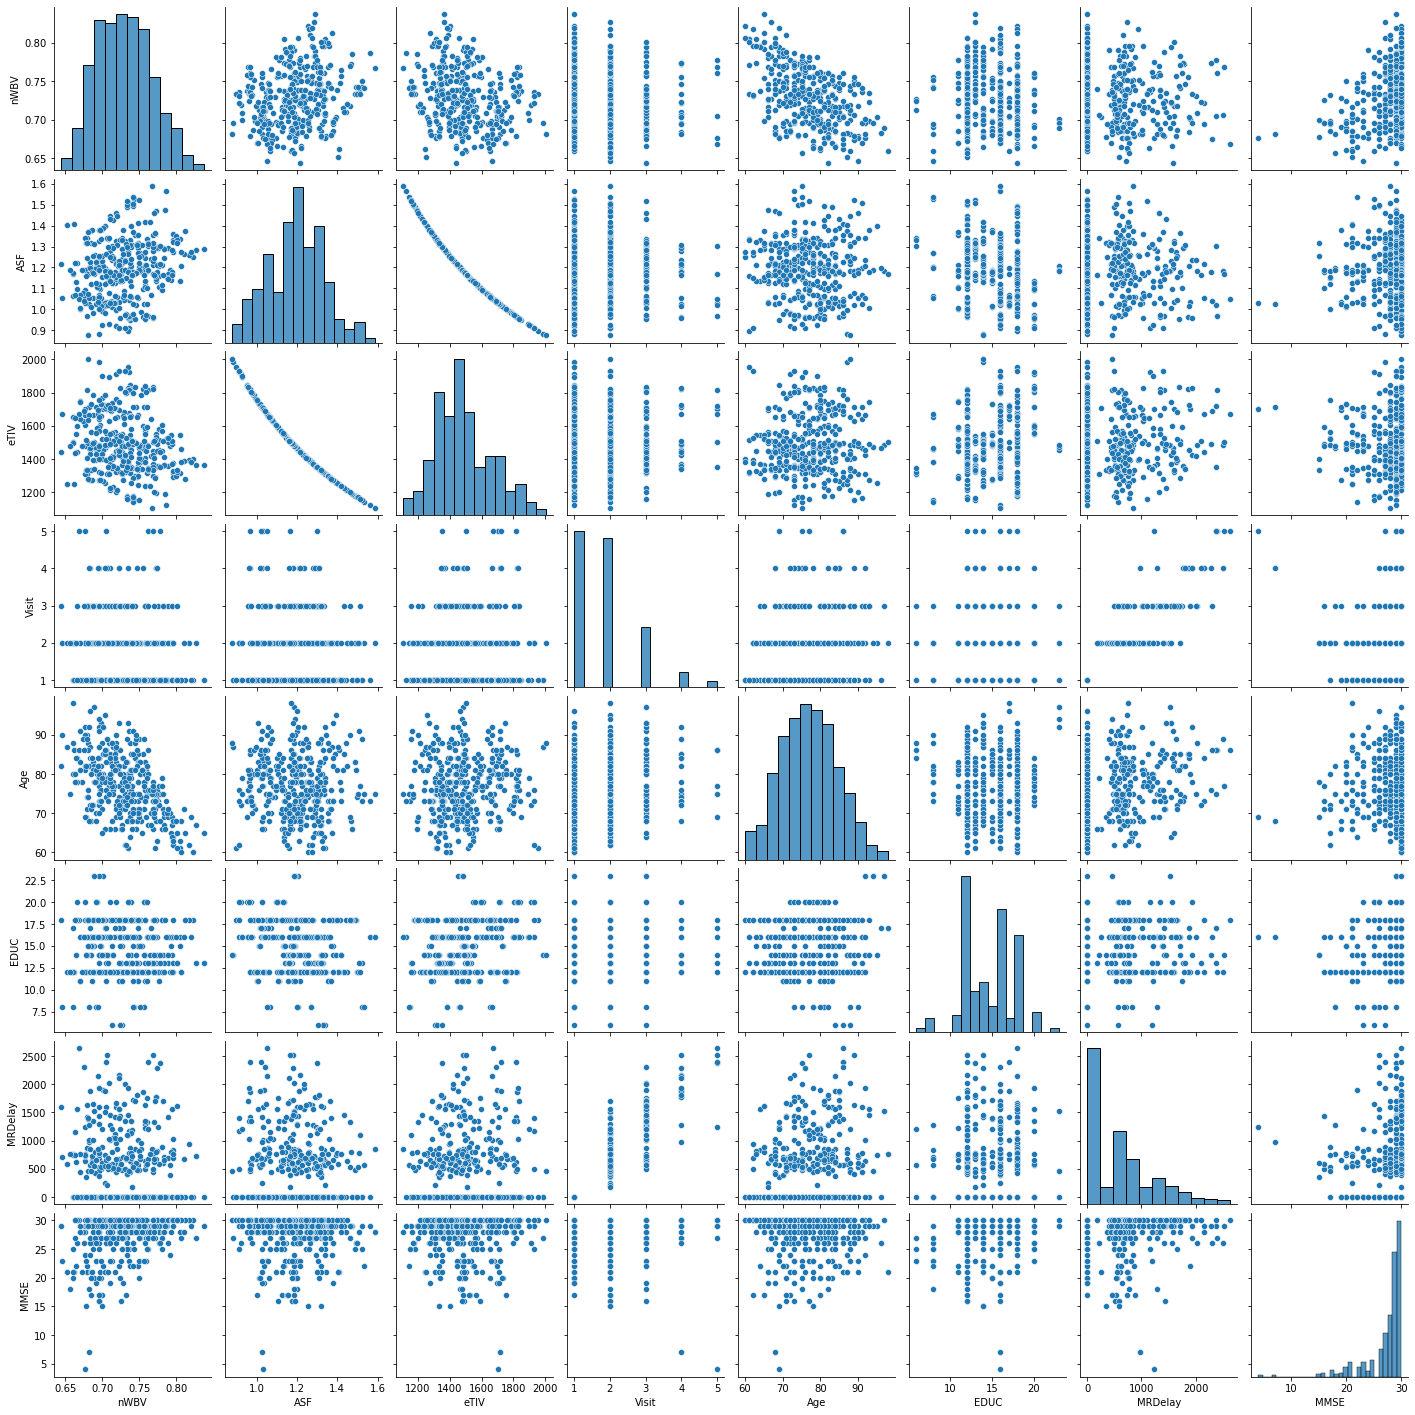

In [33]:
sns.pairplot(data[variables_quantitatives]);

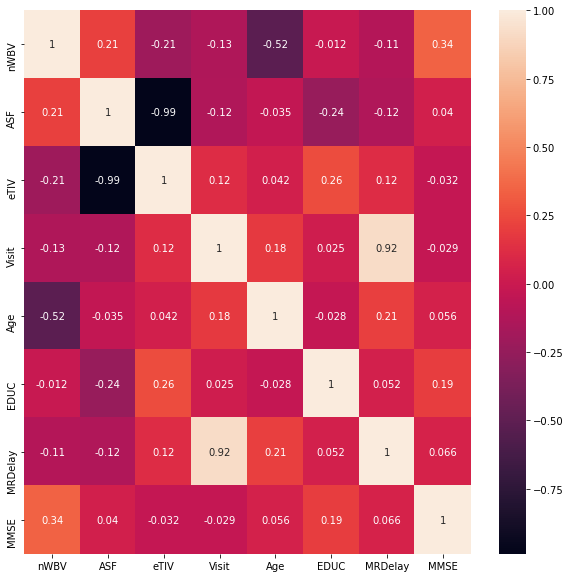

In [34]:
plt.figure(figsize = (10,10));
sns.heatmap(data[variables_quantitatives].corr(), annot = True);

- Relation entre eTIV/ASF: les variables sont parfaitement corrélées négativement.
La variable ASF est une transformation affine de la variable eTIV
- Relation entre nWBV/Age: l'age du patient et le volume total du cerveau sont négativement corrélée.
- Relation EDUC/SES: les variables sont négativement corrélés. Plus le patient à fait des études et plus le statut socio-économique est élevé.

### Analyse multivariée entre variables catégorielles

### Test du chi2

In [35]:
for indice1, colonne1 in enumerate(variables_qualitatives):
    for indice2, colonne2 in enumerate(variables_qualitatives):
        if (indice1 < indice2):
            test=chi2_test(data[colonne1], data[colonne2])
            print(f'{colonne1} {colonne2:.<90}{test}')

Sex SES.......................................................................................H0 Rejetée
Sex CDR.......................................................................................H0 Rejetée
SES CDR.......................................................................................H0 Rejetée


### V de Cramer

In [36]:
for indice1, colonne1 in enumerate(variables_qualitatives):
    for indice2, colonne2 in enumerate(variables_qualitatives):
        if (indice1 < indice2):
            test=V_Cramer(data[colonne1], data[colonne2], data.shape[0])
            print(f'{colonne1} / {colonne2:.<90}{test.round(3)}')

Sex / SES.......................................................................................0.233
Sex / CDR.......................................................................................0.256
SES / CDR.......................................................................................0.096


Relation M/F/CDR: les femmes sont moins touchées par la démence

In [37]:
# encodage de la variable 'Sex'
data['Sex'] = data['Sex'].replace({'M':1, 'F':0})

In [38]:
data

Group  Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0        2      1        0    1   87    14  2.0  27.0  0.0  1987  0.696  0.883
1        2      2      457    1   88    14  2.0  30.0  0.0  2004  0.681  0.876
2        1      1        0    1   75    12  NaN  23.0  0.5  1678  0.736  1.046
3        1      2      560    1   76    12  NaN  28.0  0.5  1738  0.713  1.010
4        1      3     1895    1   80    12  NaN  22.0  0.5  1698  0.701  1.034
..     ...    ...      ...  ...  ...   ...  ...   ...  ...   ...    ...    ...
368      1      2      842    1   82    16  1.0  28.0  0.5  1693  0.694  1.037
369      1      3     2297    1   86    16  1.0  26.0  0.5  1688  0.675  1.040
370      2      1        0    0   61    13  2.0  30.0  0.0  1319  0.801  1.331
371      2      2      763    0   63    13  2.0  30.0  0.0  1327  0.796  1.323
372      2      3     1608    0   65    13  2.0  30.0  0.0  1333  0.801  1.317

[373 rows x 12 columns]

### Analyse multivariée entre variables explicatives catégorielles et quantitatives

In [39]:
for colonne1 in variables_quantitatives:
    for colonne2 in variables_qualitatives:
            test=anova_test(data, colonne1, colonne2)
            print(f'{colonne1} / {colonne2:.<90}{test}')

nWBV / Sex.......................................................................................H0 Rejetée
nWBV / SES.......................................................................................H0 Non rejetée
nWBV / CDR.......................................................................................H0 Rejetée
ASF / Sex.......................................................................................H0 Rejetée
ASF / SES.......................................................................................H0 Rejetée
ASF / CDR.......................................................................................H0 Non rejetée
eTIV / Sex.......................................................................................H0 Rejetée
eTIV / SES.......................................................................................H0 Rejetée
eTIV / CDR.......................................................................................H0 Non rejetée
Visit / Sex........

<h3>Autre approche pour analyser les relations entre les variables explicatives et la variable à expliquer</h3>

Il est intéressant de créer des sous ensembles à partir des modalités prises par la variable à expliquer. Le but étant d'analyser les distributions des variables explicatives en fonction des différents sous ensembles.  

In [40]:
data = pd.read_csv('oasis_longitudinal.csv')
data.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1, inplace=True)
# changement du nom des variables 'MR Delay'et 'M/F'  à cause de 'l'espace' qui peut créer des erreurs lors de l'exécution de certaine cellule
data.rename({'MR Delay':'MRDelay','M/F':'Sex'}, axis=1, inplace = True)
data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0   M   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457   M   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1        0   M   75    12  NaN  23.0  0.5  1678  0.736   
3     Demented      2      560   M   76    12  NaN  28.0  0.5  1738  0.713   
4     Demented      3     1895   M   80    12  NaN  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

### Création du sous ensemble 'Demented' 

In [41]:
demented_data = data[data['Group'] == 'Demented']
demented_data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
2   Demented      1        0   M   75    12  NaN  23.0  0.5  1678  0.736   
3   Demented      2      560   M   76    12  NaN  28.0  0.5  1738  0.713   
4   Demented      3     1895   M   80    12  NaN  22.0  0.5  1698  0.701   
10  Demented      1        0   M   71    16  NaN  28.0  0.5  1357  0.748   
11  Demented      3      518   M   73    16  NaN  27.0  1.0  1365  0.727   

      ASF  
2   1.046  
3   1.010  
4   1.034  
10  1.293  
11  1.286

### Création du sous ensemble 'NonDemented' 

In [42]:
non_demented_data = data[data['Group'] == 'Nondemented']
non_demented_data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0   M   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457   M   88    14  2.0  30.0  0.0  2004  0.681   
5  Nondemented      1        0   F   88    18  3.0  28.0  0.0  1215  0.710   
6  Nondemented      2      538   F   90    18  3.0  27.0  0.0  1200  0.718   
7  Nondemented      1        0   M   80    12  4.0  28.0  0.0  1689  0.712   

     ASF  
0  0.883  
1  0.876  
5  1.444  
6  1.462  
7  1.039

### Création du sous ensemble 'Converted' 

In [43]:
converted_data = data[data['Group'] == 'Converted']
converted_data.head()

Group  Visit  MRDelay Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
33  Converted      1        0   F   87    14  1.0  30.0  0.0  1406  0.715   
34  Converted      3      489   F   88    14  1.0  29.0  0.0  1398  0.713   
35  Converted      4     1933   F   92    14  1.0  27.0  0.5  1423  0.696   
36  Converted      1        0   M   80    20  1.0  29.0  0.0  1587  0.693   
37  Converted      2      756   M   82    20  1.0  28.0  0.5  1606  0.677   

      ASF  
33  1.248  
34  1.255  
35  1.234  
36  1.106  
37  1.093

### Variables quantitatives continues:

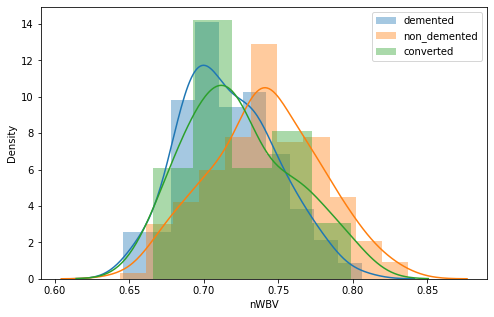

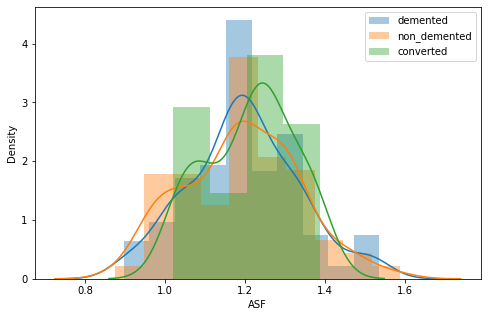

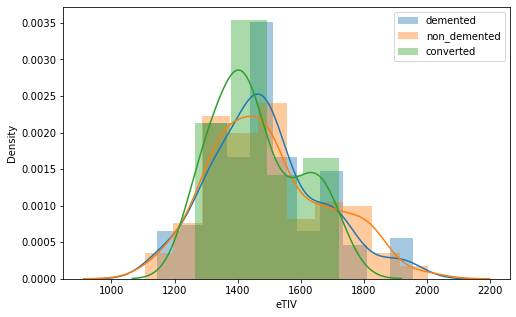

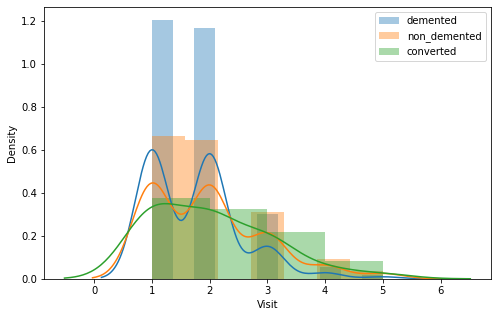

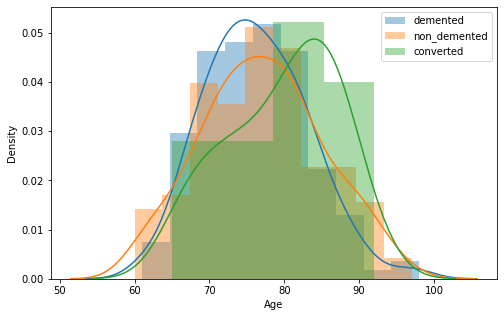

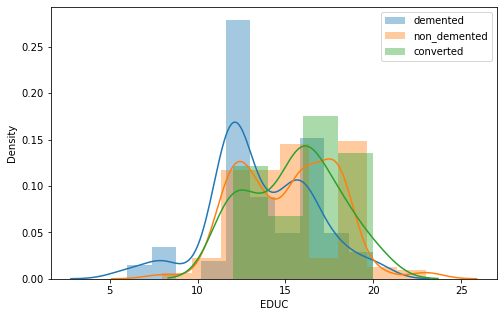

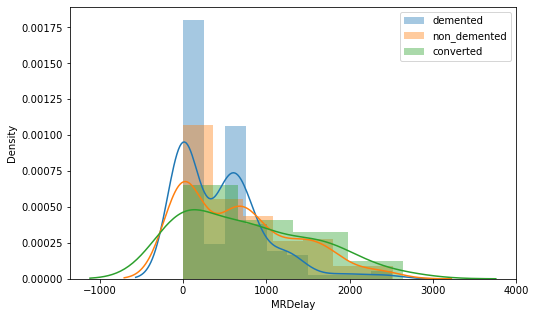

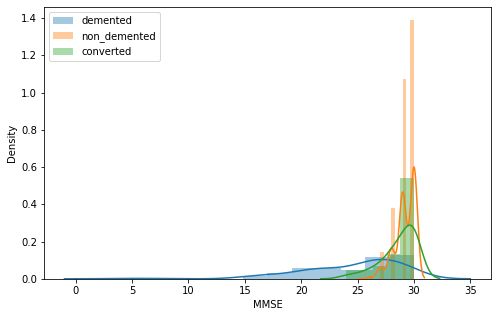

In [44]:
for colonne in variables_quantitatives:
    plt.figure(figsize=(8,5))
    sns.distplot(demented_data[colonne], label='demented')
    sns.distplot(non_demented_data[colonne], label='non_demented')
    sns.distplot(converted_data[colonne], label='converted')
    plt.legend()

Relation nWBV/target: Hypothèse: le volume total du cerveau semble lié à l'apparition de la démence.\
Relation Age/target: Hypothèse: l'âge semble lié à l'apparition de la démence.

Les variables ASF et eTIV ne semble pas lié à l'apparition de la démence chez un patients.

Relation EDUC/target: hypothèse: la durée des études semble lié à l'apparition de la démence. Plus le patient a fait de longues études et moins le risque de développer une démence est grand.

Relation MMSE/target: hypothèse: plus le score MMSE est faible et plus le risque de détecter une démence est important.

<h1>3. Data Preprocessing</h1>

# Feature engeenering

### Création de la variable 'malade'
Dans la mesure où, les lésions caractéristiques de la démence apparaissent des années avant l'apparition des symptômes, les patients qui souffrent de démence et ceux qui en développeront une, sont regroupés dans la même catégorie.\
La nouvelle variable 'malade' ainsi créée, devient la variable à expliquer, elle prend la valeur 1('Demented', 'Converted') pour un patient malade et la valeur 0('Nondemented') pour un patient non malade.

In [45]:
data = pd.read_csv('oasis_longitudinal.csv') 
data.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1, inplace=True)
# changement du nom des variables 'MR Delay'et 'M/F'  à cause de 'l'espace' qui peut créer des erreurs lors de l'exécution de certaine cellule
data.rename({'MR Delay':'MRDelay','M/F':'Sex'}, axis=1, inplace = True)
#encodage de la variable 'M/F'
data['Sex'] = data['Sex'].replace({'M':1, 'F':0})
data.head()

Group  Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0    1   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457    1   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1        0    1   75    12  NaN  23.0  0.5  1678  0.736   
3     Demented      2      560    1   76    12  NaN  28.0  0.5  1738  0.713   
4     Demented      3     1895    1   80    12  NaN  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

In [46]:
data['malade']=data['Group'].replace({'Demented':1, 'Converted':1, 'Nondemented':0})

In [47]:
# suppression de l'ancienne variable
data.drop(['Group'], axis = 1, inplace = True)
data.head()

Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  malade
0      1        0    1   87    14  2.0  27.0  0.0  1987  0.696  0.883       0
1      2      457    1   88    14  2.0  30.0  0.0  2004  0.681  0.876       0
2      1        0    1   75    12  NaN  23.0  0.5  1678  0.736  1.046       1
3      2      560    1   76    12  NaN  28.0  0.5  1738  0.713  1.010       1
4      3     1895    1   80    12  NaN  22.0  0.5  1698  0.701  1.034       1

### Création de la variable 'ratio'

'ratio': cette variable est le rapport entre le volume total de l'encéphale (nWBV) et le volume intracranien du patient (ASF). Cette nouvelle grandeur permet de mieux cerner le phénomène d'atrophie corticale.

In [48]:
data['ratio'] = data['nWBV']/data['ASF']
data.head()

Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  malade  \
0      1        0    1   87    14  2.0  27.0  0.0  1987  0.696  0.883       0   
1      2      457    1   88    14  2.0  30.0  0.0  2004  0.681  0.876       0   
2      1        0    1   75    12  NaN  23.0  0.5  1678  0.736  1.046       1   
3      2      560    1   76    12  NaN  28.0  0.5  1738  0.713  1.010       1   
4      3     1895    1   80    12  NaN  22.0  0.5  1698  0.701  1.034       1   

      ratio  
0  0.788222  
1  0.777397  
2  0.703633  
3  0.705941  
4  0.677950

### Création du sous ensemble positif

In [49]:
data_positif = data[data['malade'] == 1]

### Création du sous ensemble négatif

In [50]:
data_negatif = data[data['malade'] == 0]

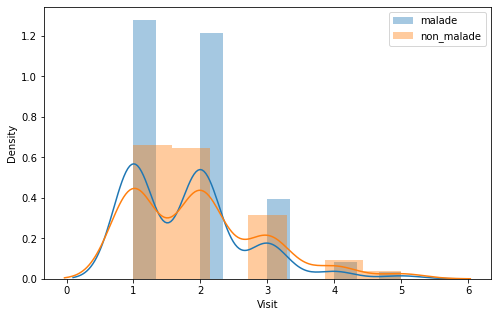

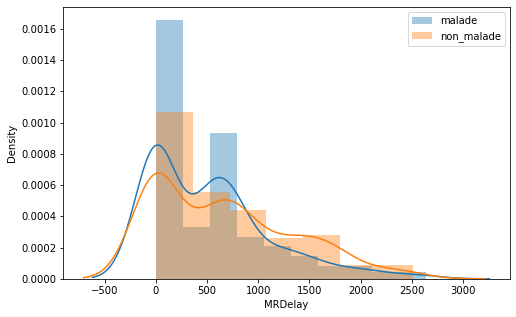

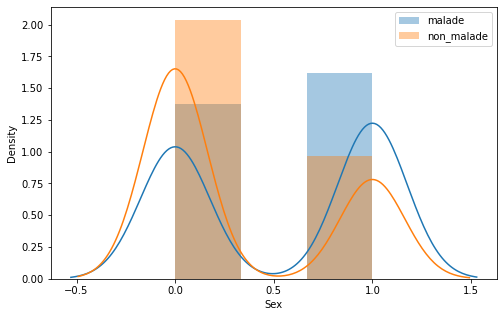

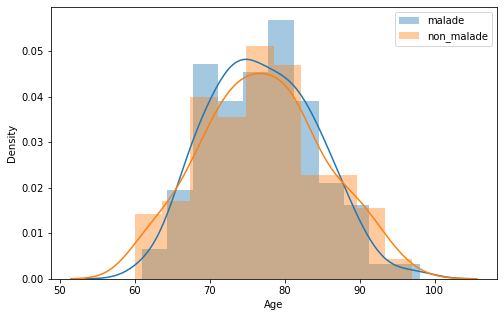

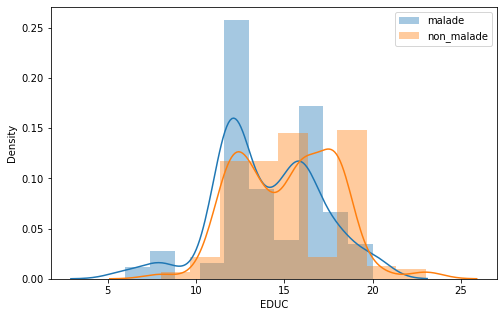

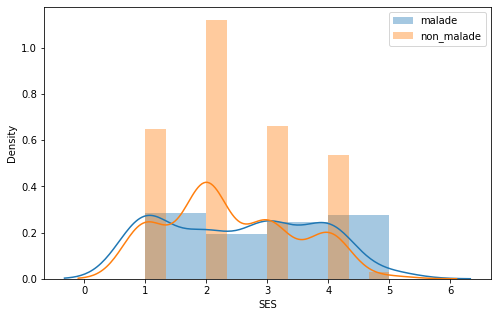

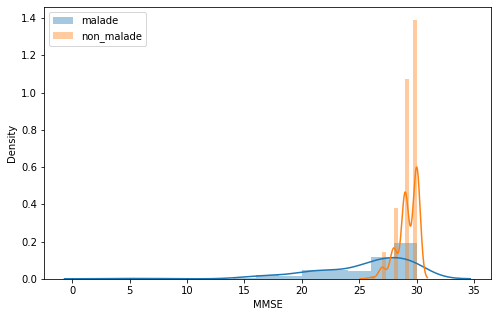

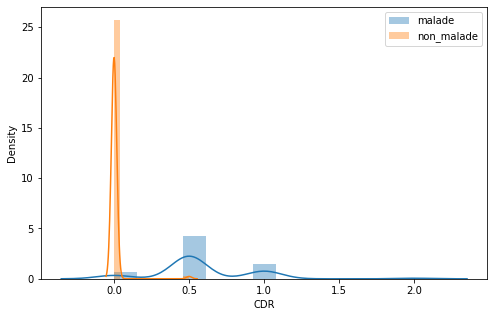

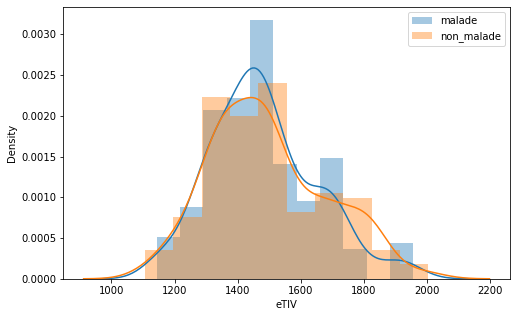

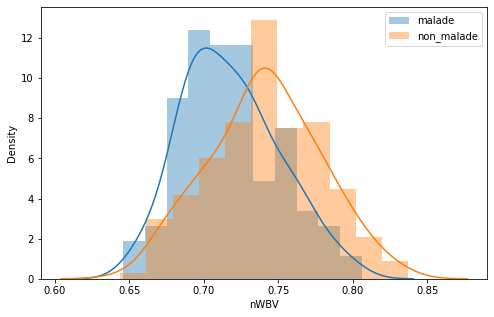

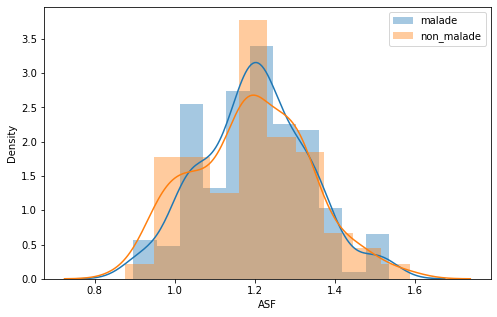

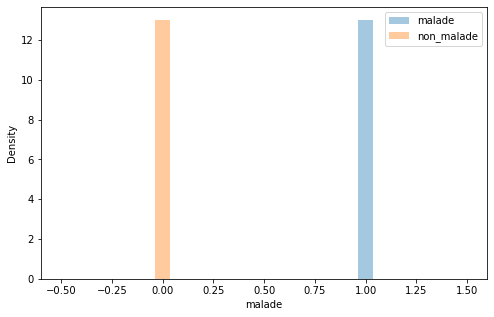

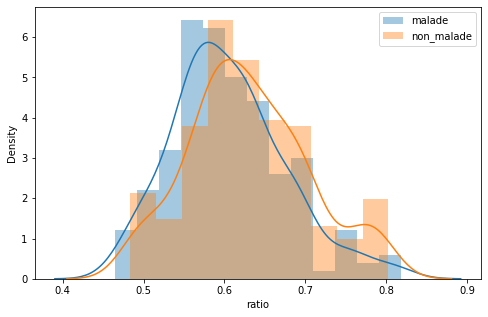

In [51]:
for colonne in data.columns:
    plt.figure(figsize=(8,5))
    sns.distplot(data_positif[colonne], label='malade')
    sns.distplot(data_negatif[colonne], label='non_malade')
    plt.legend()

<h3>Analyse des moyennes des distrubutions pour chaque sous ensemble</h3>

Relation nWBV/malade: hypothèse: il semble que les moyennes de 'nWBV' chez les indivudus malades et non malades soient différentes 

Relation MMSE/malade: hypothèse: il semble que les moyennes de 'MMSE' chez les indivudus malades et non malades soient différentes

Relation ratio/malade: hypothèse: il semble que les moyennes de 'ratio' chez les indivudus malades et non malades soient différentes

# Test statistiques 

Des tests statistiques vont être appliqués afin de vérifier les hypothèses émises précédemment 

**Test de Shapiro-Wilk**\
*Test de normalité de la distribution d'une série statistique*\
Hypothèse nulle H0: la distribution suit une loi Normale

In [52]:
def shapiro_test(colonne):
    alpha = 0.05
    stat, p = shapiro(colonne)
    if p < alpha:
        return 'H0 Rejetée', p
    else :
        return 'H0 Non rejetée'

**Test de Bartlett**\
*Test d'égalité des variances entre 2 séries statistiques*\
Hypothèse nulle H0: les variances sont égales

In [53]:
def bartlett_test(colonne):
    alpha = 0.05
    #les groupes malades et non malades n'ont pas les mêmes effectifs, il est nécéssaire de prélever autant d'échantillons dans les 2 groupes pour faire le test 
    stat, p = bartlett(data_negatif.sample(data_positif.shape[0])[colonne], data_positif[colonne])
    if p < alpha:
        return 'H0 Rejetée', p.round(3)
    else :
        return 'H0 Non rejetée'

**Test de Student**\
*Test d'égalité entre les moyennes de 2 séries statistiques, si les conditions de normalité et d'homoscédasticité sont respectées.*\
Hypothèse nulle H0: les moyennes sont égales

In [54]:
def student_test(colonne):
    alpha = 0.05
    #les groupes malades et non malades n'ont pas les mêmes effectifs, il est nécéssaire de prélever autant d'échantillons dans les 2 groupes pour faire le test 
    stat, p = ttest_ind(data_negatif.sample(data_positif.shape[0])[colonne], data_positif[colonne])
    if p < alpha:
        return 'H0 Rejetée', p.round(3)
    else :
        return 'H0 Non rejetée'

**Test de Wilcoxon**:\
*Test d'égalité entre les médianes de 2 séries statistiques si le test de normalité n'est pas respecté.*\
        Hypothèse nulle H0: les médianes sont égales

In [55]:
def wilcoxon_test(colonne):
    alpha = 0.05
    #les groupes malades et non malades n'ont pas les mêmes effectifs, il est nécéssaire de prélever autant d'échantillons dans les 2 groupes pour faire le test 
    stat, p = wilcoxon(data_negatif.sample(data_positif.shape[0])[colonne], data_positif[colonne])
    if p < alpha:
        return 'H0 Rejetée', p.round(3)
    else :
        return 'H0 Non rejetée'

 **Test de Welch**\
*Test d'égalité entre les moyennes de 2 séries statistiques, si la condition de normalité est respectée et si la condition d'homoscédasticité ne l'est pas.*\
         Hypothèse nulle H0: les moyennes sont égales

In [56]:
def welch_test(colonne):
    alpha = 0.05
    #les groupes malades et non malades n'ont pas les mêmes effectifs, il est nécéssaire de prélever autant d'échantillons dans les 2 groupes pour faire le test 
    stat, p = ttest_ind(data_negatif.sample(data_positif.shape[0])[colonne], data_positif[colonne], equal_var = False)
    if p < alpha:
        return 'H0 Rejetée', p.round(3)
    else :
        return 'H0 Non rejetée'

<h3><center>Tests statistiques sur les ratio volume encéphalique normalisé/volume intracranien normalisé, pour les patients malades et non malades</center></h3>

**Test de Shapiro-Wilk:**\
Hypothèse nulle H0: les échantillons de la variable ratio pour les sous ensemble malade et non malade présentent une distribution normale

In [57]:
shapiro_test(data_negatif['ratio'])

('H0 Rejetée', 0.0039131976664066315)

In [58]:
shapiro_test(data_positif['ratio'])

('H0 Rejetée', 0.001998744672164321)

Les échantillons de la variable ratio pour les sous ensemble malade et non malade ne pas présentent une distribution normale.\
Un test de Wilcoxon est préconisé pour comparé les échantillons de la variable ratio pour les sous ensemble 'positif' et 'negatif'

**Test de Wilcoxon**:\
Hypothèse nulle H0: Les ratios 'volume encéphalique normalisé/volume intracranien normalisé' sont similaires chez les patients souffrant de démence et ceux ne souffrant pas de démence.

In [59]:
colonne = 'ratio'
print(f'{colonne :.<90}{wilcoxon_test(colonne)}')

ratio.....................................................................................('H0 Rejetée', 0.001)


Les ratios 'volume encéphalique normalisé/volume intracranien normalisé' sont significativement différents chez les patients souffrant de démence et ceux ne souffrant pas de démence, au seuil de risque de 5%.

<h3><center>Tests statistiques sur les niveaux d'instructions des patients malades et non malades </center></h3>

Visuellement, il est clair que les distributions de la variable 'EDUC' pour les sous ensembles 'positif' et 'negatif' ne présentent pas une distribution normale.
Un test de Wilcoxon est préconisé pour comparé les échantillons de la variable 'EDUC' pour les sous ensemble 'positif' et 'negatif'

**Test de Wilcoxon**: H0: les niveaux d’instructions sont similaires chez les patients souffrant de démence et ceux ne souffrant pas de démence.

In [60]:
colonne = 'EDUC'
print(f'{colonne :.<90}{wilcoxon_test(colonne)}')

EDUC......................................................................................('H0 Rejetée', 0.0)


Les niveaux d’instructions sont significativement différents chez les patients souffrant de démence et ceux ne souffrant pas de démence.

# 3. Data preprocessing

### Encodage

In [61]:
data = pd.read_csv('oasis_longitudinal.csv') 
data.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1, inplace=True)
data['malade']=data['Group'].replace({'Demented':1,'Converted':1, 'Nondemented':0})
data['ratio'] = data['nWBV']/data['ASF']

In [62]:
data['M/F'] = data['M/F'].replace({'M':1, 'F':0})
data.rename({'MR Delay':'MRDelay','M/F':'Sex'}, axis=1, inplace = True)
data.head()

Group  Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0    1   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457    1   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1        0    1   75    12  NaN  23.0  0.5  1678  0.736   
3     Demented      2      560    1   76    12  NaN  28.0  0.5  1738  0.713   
4     Demented      3     1895    1   80    12  NaN  22.0  0.5  1698  0.701   

     ASF  malade     ratio  
0  0.883       0  0.788222  
1  0.876       0  0.777397  
2  1.046       1  0.703633  
3  1.010       1  0.705941  
4  1.034       1  0.677950

### Imputation

Les valeurs manquantes pour les variables 'SES' et 'MMSE' sont remplacer par le mode de chaque série statistique

In [63]:
data['SES'] = data['SES'].fillna(data_positif['SES'].mode()[0])
data['MMSE'] = data['MMSE'].fillna(data_positif['MMSE'].mode()[0])
data.head()

Group  Visit  MRDelay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1        0    1   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2      457    1   88    14  2.0  30.0  0.0  2004  0.681   
2     Demented      1        0    1   75    12  1.0  23.0  0.5  1678  0.736   
3     Demented      2      560    1   76    12  1.0  28.0  0.5  1738  0.713   
4     Demented      3     1895    1   80    12  1.0  22.0  0.5  1698  0.701   

     ASF  malade     ratio  
0  0.883       0  0.788222  
1  0.876       0  0.777397  
2  1.046       1  0.703633  
3  1.010       1  0.705941  
4  1.034       1  0.677950

### Selection de variable

- **Features Selection**

   - **Variables quantitatives**: 
        - nWBV: éliminée car l'information de cette variable explicative est contenue dans la variable ratio
        - ASF: éliminée car l'information de cette variable explicative est contenue dans la variable ratio
        - eTIV: éliminée car l'information de cette variable explicative est contenue dans la variable ASF
        - Visit: éliminée car le nombre de visiste n'a pas de lien avec la détection de la maladie
        - MR Delay: éliminée car cette variable explicative est inconnue 
        - Age: conservée car l'âge d'un patient est lié à la maladie
        - EDUC: conservé car le niveau d'éducation est lié à la maladie
        - MMSE: conservé car cette variable explicative est nécéssaire au diagnostique de la maladie
        - ratio: conservé car cette variable explicative est nécéssaire au diagnostique de la maladie
   - **Variables qualitatives**:
        - SES: conservé car le statut est lié à la maladie
        - CDR: éliminé car cette variable explicative est un indicateur qui mesure la sévérité de la démence, elle ne peut pas  en être la cause.
        - Group: éliminée car cette ancienne variable à expliquer est remplacé par la nouvelle variable malade  
        - M/F: conservée car le sexe du patient est lié à la maladie 
        - Malade: conservée car c'est la nouvelle variable à expliquée

In [64]:
features = data.drop(['Group','Visit', 'eTIV', 'ASF', 'CDR','malade','nWBV', 'MRDelay'], axis = 1)
target = data['malade']

In [65]:
features.head()

Sex  Age  EDUC  SES  MMSE     ratio
0    1   87    14  2.0  27.0  0.788222
1    1   88    14  2.0  30.0  0.777397
2    1   75    12  1.0  23.0  0.703633
3    1   76    12  1.0  28.0  0.705941
4    1   80    12  1.0  22.0  0.677950

### Séparation du jeu de données

In [66]:
# 80% des données placées dans le jeu d'entrainement, 20% des données placées dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(features, target , test_size = 0.2, random_state=0)

# 4. Fonctions d'évaluations

### Courbes d'apprentissages

En fonction de la métrique choisie, les courbes d'apprentissage déterminent les scores sur les jeux de données d'entrainement et de validation, par la méthode de validation croisée. Ces courbes permettent la détection du phénomène de sur-entrainement.

In [67]:
def courbe_apprentissage(model):
    
    N, train_score, val_score = learning_curve(model, 
                                               X_train, 
                                               y_train, 
                                               cv=4, 
                                               scoring = 'recall', 
                                               train_sizes = np.linspace(0.1,1,10))
    
    plt.figure(figsize = (8,6))
    plt.plot(N, train_score.mean(axis = 1), label = 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.grid()
    plt.legend();

### Rapport de classification

Le rapport de classification reprend sous forme d'un tableau, les différentes métriques de classification (precision, recall, f1-score) pour chacune des classes.

In [68]:
def rapport_classification(model):
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

### Matrice de confusion

Elle mesure la capacité d'un modèle à classifier correctement les échantillons prédits, dans les classes auxquelles ils appartiennent en réalité.

In [69]:
def matrice_confusion(model):
    
    y_pred = model.predict(X_test)
 
    cm=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest',cmap='Greens')
    plt.title("Matrice de confusion")
    tick_marks = np.arange(len(list(target.unique())))
    plt.xticks(tick_marks, list(target.unique()))
    plt.yticks(tick_marks, list(target.unique()))
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

### Courbe ROC

Cette courbe mesure la performance d'un modèle de classification binaire. Le graphique montre l'évolution de la sensibilité en fonction de l'anti-spécificité, selon différents seuil de classification.

In [70]:
def courbe_roc(model):
    
    y_prob = model.predict_proba(X_test)
    
    # calcul de la sensibilité et de l'anti-spécificité pour différents seuils de probabilité
    fpr, tpr, seuils = roc_curve(y_test, y_prob[:,1], pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    # affichage de la sensibilté en fonction de l'anti-spécificité
    plt.figure(figsize = (8,6))
    plt.plot(fpr, tpr, color='orange', lw=2, label = 'Modèle clf (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Aléatoire (auc = 0.5)')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux faux positifs')
    plt.ylabel('Taux vrais positifs')
    plt.title('Courbe ROC')
    plt.grid()
    plt.legend(loc = "lower right")

### Courbe precision recall

Cette courbe montre l'évolution de la précision et du recall, en fonction de différentes valeurs de seuil de classification.

In [71]:
def courbe_precision_recall(model):
    
    precision, recall, threshold = precision_recall_curve(y_test, model.decision_function(X_test))
    
    plt.figure(figsize = (8,6))
    plt.plot(threshold, precision[:-1], label = 'precision')
    plt.plot(threshold, recall[:-1], label = 'recall')
    plt.grid();
    plt.title('Courbe Precision Recall');
    plt.legend();

# 5. Modélisations

<h3><center>Première modélisation avec un arbre de décision</center></h3>

La première modélisation s'effectue avec un arbre de décision, il n'est pas nécessaire de normaliser les données avec ce type d'estimateur.

              precision    recall  f1-score   support

           0       0.77      0.97      0.86        38
           1       0.96      0.70      0.81        37

    accuracy                           0.84        75
   macro avg       0.87      0.84      0.84        75
weighted avg       0.87      0.84      0.84        75



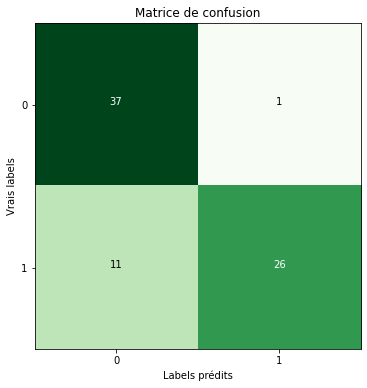

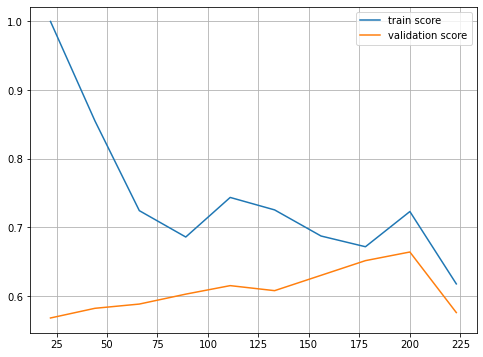

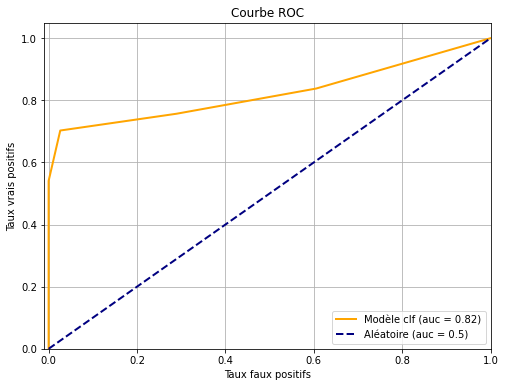

In [72]:
model = DecisionTreeClassifier(random_state=0, max_depth=3)

model.fit(X_train, y_train)
rapport_classification(model)
matrice_confusion(model)
courbe_apprentissage(model)
courbe_roc(model)

- **Rapport de classification et matrice de confusion**\
Les patients malades sont bien prédits et les patients non malade sont bien détectés.
- **Courbes d'apprentissage**\
Les scores sur les courbes d'apprentissage et de validation convergent. Pas de phénomène d'overfitting détecté. Cependant le taux de bonnes prédictions est plutôt faible.
- **Courbe ROC**\
La courbe montre que la sensibilité augmente lentement, à mesure que le seuil de discrimination pour la classe positive baisse. 

### Features importance

In [73]:
pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['Importance']).sort_values(by = 'Importance', ascending = False)

Importance
MMSE     0.718550
ratio    0.130096
Sex      0.078947
SES      0.051111
EDUC     0.021296
Age      0.000000

- **Features importance**: 
 - MMSE: 0.54 La variable MMSE est de loin celle qui à la pondération la plus importante dans le cadre de la détection de la démence.
 - ratio:  0.19 Dans une moindre mesure, la variable ratio joue également un rôle dans la prédiction.
 - Age: 0.09 L'impact des autres variables (Age, EDUC, M/F et SES) est marginal sur la classification.
 - EDUC: 0.07
 - M/F: 0.05
 - SES: 0.05

### Visualisation de l'arbre de décision

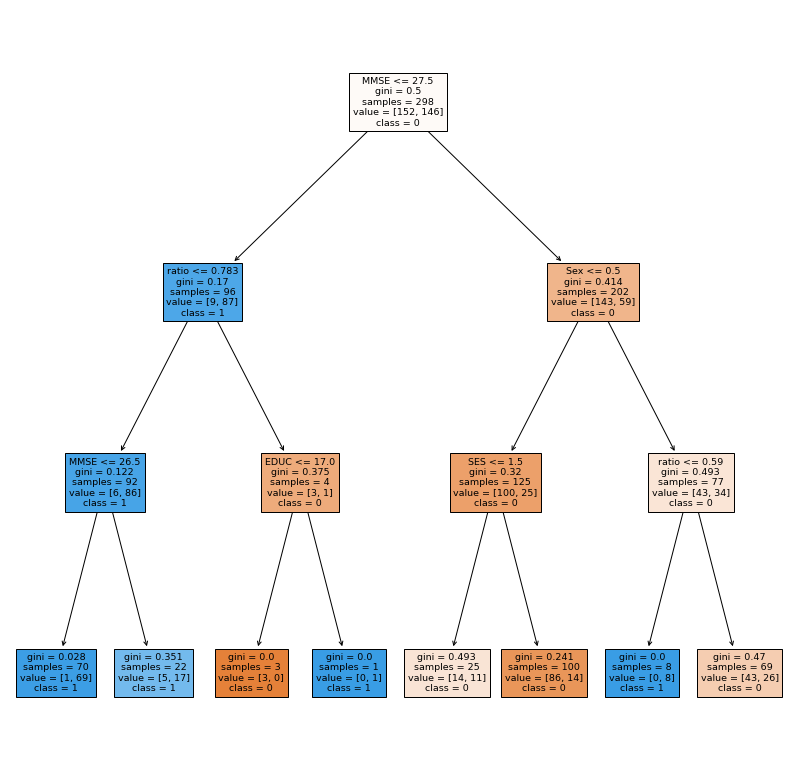

In [74]:
plt.figure(figsize = (14,14))
plot_tree(model, feature_names = X_train.columns , class_names = np.unique(y_train.astype(str)), filled = True);

<h3><center>Autres modélisations</center></h3>

In [75]:
# les estimateurs basés sur des arbres de décision n'ont pas besoin de données normalisées 
RandomForest = RandomForestClassifier(random_state = 0)
AdaBoost = AdaBoostClassifier(random_state = 0)
XgBoost = XGBClassifier(random_state = 0)

# on utilise des pipelines pour normaliser les données et leur appliquer un estimateur
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
SVM = make_pipeline(StandardScaler(), SVC(random_state = 0, probability=True))
LogisticRegression = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))

In [76]:
liste_model = {'RandomForest': RandomForest, 
               'SVM': SVM, 
               'KNN': KNN,
               'Adaboost': AdaBoost,
               'LogisticRegression': LogisticRegression,
               'XgBoost': XgBoost
              }

In [77]:
for name, model in liste_model.items():
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()

RandomForest
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        38
           1       0.94      0.84      0.89        37

    accuracy                           0.89        75
   macro avg       0.90      0.89      0.89        75
weighted avg       0.90      0.89      0.89        75

[[36  2]
 [ 6 31]]

SVM
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        38
           1       1.00      0.76      0.86        37

    accuracy                           0.88        75
   macro avg       0.90      0.88      0.88        75
weighted avg       0.90      0.88      0.88        75

[[38  0]
 [ 9 28]]

KNN
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        38
           1       0.93      0.76      0.84        37

    accuracy                           0.85        75
   macro avg       0.87      0.85      0.85        75
weighted avg 

Les estimateurs RandomForestClassifier et SVM donnent les meilleurs résultats en terme de précision, de recall, de f1-score et d'accuracy. Ces 2 estimateurs sont retenus pour des opérations de fine tuning.

# 6. Optimisation des estimateurs choisis

### Premier estimateur: RandomForestClassifier

In [78]:
model = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 50)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)

In [79]:
import pickle

# sauvegarde du modèle
pickle.dump(model, open('model.pkl', 'wb'))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        38
           1       0.94      0.81      0.87        37

    accuracy                           0.88        75
   macro avg       0.89      0.88      0.88        75
weighted avg       0.89      0.88      0.88        75



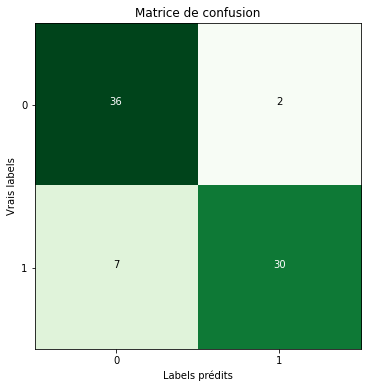

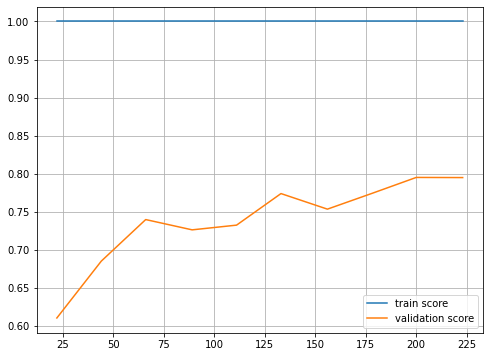

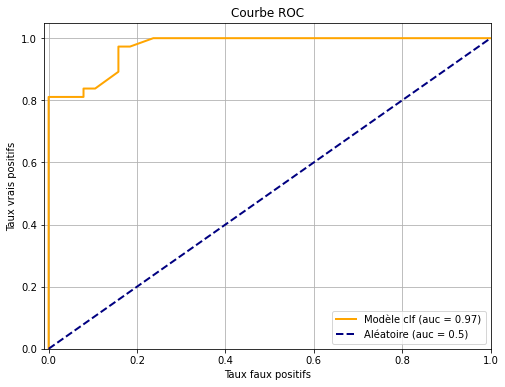

In [80]:
rapport_classification(model)
matrice_confusion(model)
courbe_apprentissage(model)
courbe_roc(model)

In [81]:
pd.DataFrame(model.fit(X_train, y_train).feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

Importance
MMSE     0.359372
ratio    0.224841
Age      0.141462
SES      0.108071
EDUC     0.103796
Sex      0.062458

In [82]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### Grille de recherche

In [83]:
# la grille de recherche permet de trouver les meilleurs hyperparamètres du modèle
grid = GridSearchCV(model, {'max_depth': range(2,10), 'max_features':range(2,10)}, cv=4)

In [84]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              random_state=0),
             param_grid={'max_depth': range(2, 10),
                         'max_features': range(2, 10)})

In [85]:
grid.best_estimator_

RandomForestClassifier(max_depth=6, max_features=2, n_estimators=50, n_jobs=-1,
                       random_state=0)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.97      0.81      0.88        37

    accuracy                           0.89        75
   macro avg       0.90      0.89      0.89        75
weighted avg       0.90      0.89      0.89        75



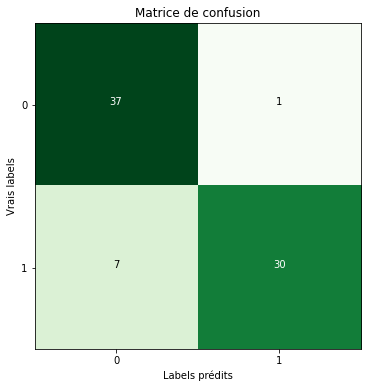

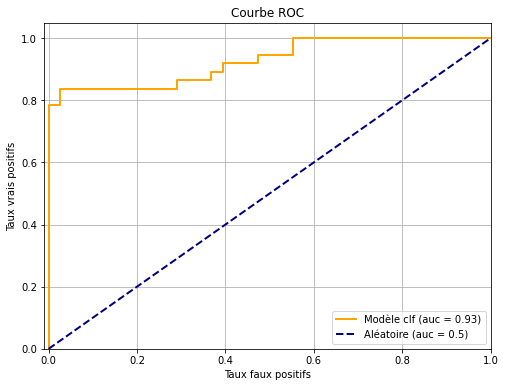

In [86]:
rapport_classification(grid)
matrice_confusion(grid)
courbe_roc(grid)

In [87]:
fig, axes = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10), dpi=900)

for index in range(0, 2):
    plot_tree(model.estimators_[index],
                   feature_names = X_train.columns, 
                   class_names=['0','1'],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

### Deuxième estimateur: SVM

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        38
           1       1.00      0.76      0.86        37

    accuracy                           0.88        75
   macro avg       0.90      0.88      0.88        75
weighted avg       0.90      0.88      0.88        75



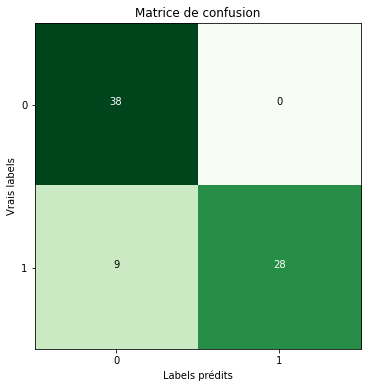

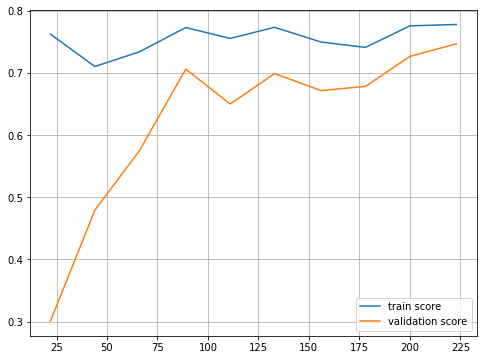

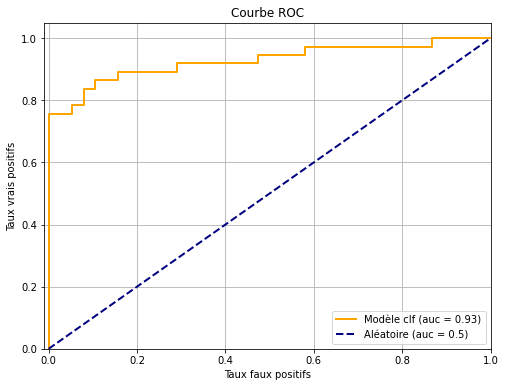

In [88]:
model = SVM
model.fit(X_train, y_train)
rapport_classification(model)
matrice_confusion(model)
courbe_apprentissage(model)
courbe_roc(model)

In [89]:
SVM.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('svc', SVC(probability=True, random_state=0))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(probability=True, random_state=0),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': 0,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [90]:
params = {'svc__gamma':[.01, .1, 1e-2, 1e-3, 1e-4], 
          'svc__C':[0.1, 10, 100, 1000],
          'svc__kernel':['linear', 'poly', 'rbf'],
          'svc__degree': [1, 2, 3, 4, 5]
         }

In [91]:
grid = GridSearchCV(SVM, params, scoring = 'recall' , cv = 4)

In [92]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=0))]),
             param_grid={'svc__C': [0.1, 10, 100, 1000],
                         'svc__degree': [1, 2, 3, 4, 5],
                         'svc__gamma': [0.01, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             scoring='recall')

In [93]:
grid.best_params_

{'svc__C': 100, 'svc__degree': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        38
           1       0.88      0.81      0.85        37

    accuracy                           0.85        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.86      0.85      0.85        75



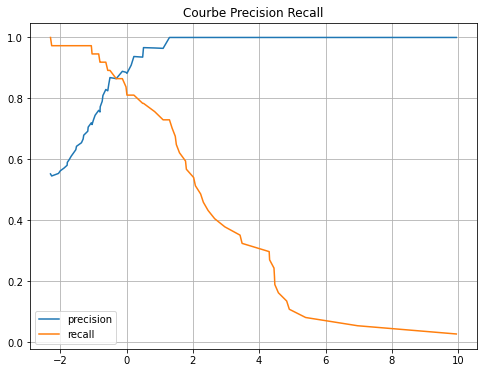

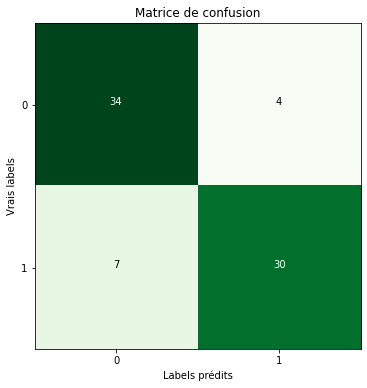

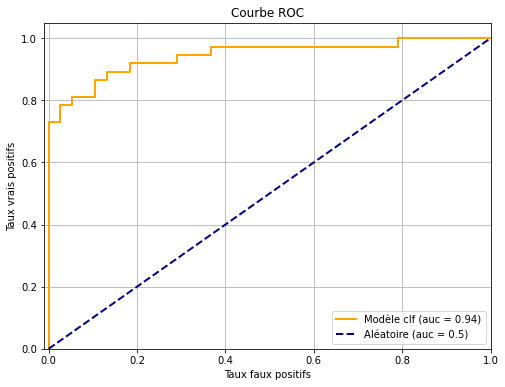

In [94]:
rapport_classification(grid)
courbe_precision_recall(grid)
matrice_confusion(grid)
courbe_roc(grid)

In [95]:
def model_final(model, X, threshold = 0):
    return model.decision_function(X) > threshold

A partir de la courbe precision recall, le seuil à choisir afin d'avoir un bon compromis entre precision est recall est de -0.5

In [96]:
y_pred = model_final(grid, X_test, -0.5)

In [97]:
confusion_matrix(y_test, y_pred)

array([[33,  5],
       [ 5, 32]], dtype=int64)

In [98]:
recall_score(y_test, y_pred)

0.8648648648648649

In [99]:
f1_score(y_test, y_pred)

0.8648648648648649

# 7. Conclusion

Après optimisation des hyperparamètres de l'estimateur RandomForestClassifier, il s'avère que ce dernier fournit les meilleurs métriques, parmi tous les modèles testés.
 

Pour la classe des patients malades, les métriques sont les suivantes:
- Précision: 97%
- Recall: 84%
- F1 Score: 90%

La classe des patients malades est donc correctement prédite et détectée par la modélisation finale.

Le taux de bonne prédiction(Accuracy) du modèle est de 91% et son score AUC est de 0.94, cette modèlisation est considérée comme performante pour répondre à notre problématique.